# Bias types (Kilosort 3.0)

author: steeve.laquitaine@epfl.ch  
last modified: 13-02-2024
status: OK  
regression: None  

Purpose: Characterize and quantify ground truth sorting quality and biases from matching with best matching sorted units

Notes:
* pros of Kilosort 3.0:
    * fully automated to produce single units (isolated from multi-units via additional postprocessing label "KSlabel")
    * very efficient algorithm
    * very recent and well maintained, was very easy to setup and run from SpikeInterface
    * the most used and cited by recent studies, in high-impact papers


We define biases types to characterize what happens to the true units (not with respect to sorted unit). This allows the proportion of all biases to sum to 100% over true units.

Based on our definitions:

* Possible biases types are:  
    * well detected
    * well detected + correlated unit
    * poorly detected    
    * oversplit
    * overmerged (include overmerged + poorly detected because this combination is always due to overmerging)   
    * overmerged + oversplit
    * overmerged + well detected + correlated unit
    * below chance    
    * missed
* Impossible biases types are:
    * poorly detected + oversplit (impossible because poorly detected requires matching at max a single sorted unit above chance, while oversplit requires matching at least two units)


To detect overmerged units and combinations

* need to look from perspective of sorted units
* A true unit is overmerged (with other true units) if it has at least one sorted units with a score between detection and chance that also has a score between detection and chance with another true unit.
* a poorly sorted units (accuracy between 0.1 and 0.8) can thus be overmerged (it fuse together half the spike trains of two true units). In that case it is classified as overmerged.


### Setup

Create or activate env `npx_10m_384ch_unit_classes`

In [1]:
%load_ext autoreload
%autoreload 2
import os 
from matplotlib import pyplot as plt
import numpy as np
from collections import Counter
import pandas as pd
import seaborn as sns 
import spikeinterface as si

proj_path = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/spikebias/"
os.chdir(proj_path)

from src.nodes.postpro.cell_matching import get_SpikeInterface_matching_object, match_sorted_to_true_neuropixels_2023_02_19
from src.nodes.utils import get_config
from src.nodes.postpro.feateng import (add_firing_rates)
from src.nodes.postpro import spikestats

# set classification parameters
LOW_RATE_CEILING = 0.2  # max firing rate where negative proba change is observed in "bias plot" (sparse units)
DET_THRESH = 0.8
CHANCE_THRESH = 0.1

# buccino
data_conf, param_conf = get_config("buccino_2020", "2020").values()
KS3_SORTING_PATH_b = data_conf["sorting"]["sorters"]["kilosort3"]["output"]
GT_SORTING_PATH_b = data_conf["sorting"]["simulation"]["ground_truth"]["output"]
RECORDING_PATH_b = data_conf["recording"]["output"]
KS3_SORTING_PATH_b = data_conf["sorting"]["sorters"]["kilosort3"]["output"]

# silico marques
data_conf, param_conf = get_config("silico_neuropixels", "2023_10_18").values()
KS3_SORTING_PATH_m = data_conf["sorting"]["sorters"]["kilosort3"]["output"]
GT_SORTING_PATH_m = data_conf["sorting"]["simulation"]["ground_truth"]["output"]
RECORDING_PATH_m = data_conf["recording"]["output"]
KS3_SORTING_PATH_m = data_conf["sorting"]["sorters"]["kilosort3"]["output"]

# silico horvath
data_conf, param_conf = get_config("silico_horvath", "concatenated/probe_1").values()
KS3_SORTING_PATH_h = data_conf["sorting"]["sorters"]["kilosort3"]["output"]
GT_SORTING_PATH_h = data_conf["sorting"]["simulation"]["ground_truth"]["output"]
RECORDING_PATH_h = data_conf["recording"]["output"]
KS3_SORTING_PATH_h = data_conf["sorting"]["sorters"]["kilosort3"]["output"]

# silico stimulus
data_conf, param_conf = get_config("silico_neuropixels", "stimulus").values()
KS3_SORTING_PATH_e = data_conf["sorting"]["sorters"]["kilosort3"]["output"]
GT_SORTING_PATH_e = data_conf["sorting"]["simulation"]["ground_truth"]["output"]
RECORDING_PATH_e = data_conf["recording"]["output"]
KS3_SORTING_PATH_e = data_conf["sorting"]["sorters"]["kilosort3"]["output"]


# FIGURE SETTINGS
COLOR_VIVO = (0.7, 0.7, 0.7)
COLOR_SILI = (0.84, 0.27, 0.2)
COLOR_STIM = (0.6, 0.75, 0.1)
BOX_ASPECT = 1                  # square fig
FIG_SIZE = (1,1)
plt.rcParams['figure.figsize'] = (2,1)
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 6
plt.rcParams['lines.linewidth'] = 0.2
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.major.width'] = 0.3
plt.rcParams['xtick.minor.size'] = 0.1
plt.rcParams['xtick.major.size'] = 1.5
plt.rcParams['ytick.major.size'] = 1.5
plt.rcParams['ytick.major.width'] = 0.3
legend_cfg = {"frameon": False, "handletextpad": 0.1}
savefig_cfg = {"transparent":True}
# print(plt.rcParams.keys())

2024-02-15 09:58:38,574 - root - utils.py - get_config - INFO - Reading experiment config.
2024-02-15 09:58:38,603 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-02-15 09:58:38,605 - root - utils.py - get_config - INFO - Reading experiment config.
2024-02-15 09:58:38,678 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-02-15 09:58:38,680 - root - utils.py - get_config - INFO - Reading experiment config.
2024-02-15 09:58:38,717 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-02-15 09:58:38,719 - root - utils.py - get_config - INFO - Reading experiment config.
2024-02-15 09:58:38,770 - root - utils.py - get_config - INFO - Reading experiment config. - done


### Define custom functions

In [2]:
def format_agreement_matrix(MatchingObject):

    # get sorted x true units' agreement scores
    overmerging_matx = MatchingObject.agreement_scores.T

    # sort each row such that the row with the highest score be first, while column order stays unchanged
    argmax = overmerging_matx.T.idxmax().to_frame()
    max = overmerging_matx.T.max()
    descending_ix = np.argsort(max)[::-1]
    overmerging_matx_2 = overmerging_matx.iloc[descending_ix]

    # repeat for columns, row order stays auntouched
    argmax = overmerging_matx_2.idxmax().to_frame()
    max = overmerging_matx_2.max()
    descending_ix = np.argsort(max)[::-1]
    return overmerging_matx_2.iloc[:, descending_ix]


def classify_true_unit_biases(overmerging_matx_2, det_thresh, chance):

    # create masks
    mask_above_det = overmerging_matx_2 >= det_thresh
    mask_below_chance = overmerging_matx_2 <= chance
    mask_in_between = np.logical_and(
        overmerging_matx_2 < det_thresh, overmerging_matx_2 > chance
    )
    mask_entirely_missed = overmerging_matx_2 == 0

    # implement tree to classify ground truths
    # find ground truth (cols) with one mask_above_det=True and other mask_below_chance = True

    gt_classes = []

    # loop over ground truth units
    for gt_i in range(overmerging_matx_2.shape[1]):

        # check if that ground truth has a single sorted unit
        # with an agreement score above detection threshold
        if any(mask_above_det.iloc[:, gt_i]):

            # get this ground truth detection stata
            is_detected = mask_above_det.iloc[:, gt_i]
            detected_loc = np.where(is_detected)[0]
            detected_ix = is_detected.index[detected_loc]

            # get other cells
            other_cells_ix = is_detected.drop(index=detected_ix).index

            # get this ground truth below chance stata
            is_below_chance = mask_below_chance.iloc[:, gt_i]

            # check if all other sorted units are below chance
            if all(is_below_chance.loc[other_cells_ix]):
                gt_classes.append("well detected")
            # if another unit has an agreement score
            # above chance level, it is: well detected + correlated unit
            else:
                gt_classes.append("well detected, correlated")

        # case where ground truth matches only one sorted unit
        # with a score b/w detection and chance and
        # other units below chance
        # no score are above detection
        elif (sum(mask_in_between.iloc[:, gt_i]) == 1) and (
            any(mask_above_det.iloc[:, gt_i]) == False
        ):
            gt_classes.append("poorly detected")

        # case a true unit is associated is a sorted unit with score
        # between detection and chance that is associated with other
        # true units with scores between detection and chances
        elif sum(mask_in_between.iloc[:, gt_i]) > 1:
            gt_classes.append("oversplit")

        # check that all sorted units have scores below
        # chance
        elif all(mask_below_chance.iloc[:, gt_i]):
            if all(mask_entirely_missed.iloc[:, gt_i]):
                gt_classes.append("missed")
            else:
                gt_classes.append("below chance")

    # Detect overmerged units and combinations -------------

    # if one of its sorted units with score between
    # detection and chance has also a score between
    # detection and chance with another true unit
    # the true unit is overmerged (with another true unit)
    true_units_loc = np.where(mask_in_between.sum(axis=0) >= 1)[0]
    true_units = mask_in_between.columns[true_units_loc]
    gt_overmerged = dict()

    for gt_i in range(len(true_units_loc)):
        target_true_units_mx = mask_in_between.iloc[:, true_units_loc]
        sorted_u = np.where(target_true_units_mx.iloc[:, gt_i])[0]

        # check overmerged (that sorted unit merges other true units)
        if any(mask_in_between.iloc[sorted_u, :].sum(axis=1) > 1):
            overmerged_bool = mask_in_between.iloc[sorted_u, :].sum(axis=1) > 1
            overmerging_sorted = overmerged_bool.index[
                np.where(overmerged_bool)[0]
            ].to_list()
            gt_overmerged[true_units[gt_i]] = overmerging_sorted

    # what other biases do overmerged units have?
    all_true_units = overmerging_matx_2.columns
    gt_classes_df = pd.DataFrame(data=gt_classes, index=all_true_units.to_list())
    print(
        "combination of biases:", np.unique(gt_classes_df.loc[gt_overmerged.keys(), :])
    )

    # label combination of biases
    gt_classes_df.loc[gt_overmerged.keys(), :] = gt_classes_df.loc[
        gt_overmerged.keys(), :
    ].apply(lambda x: x + ", overmerged")

    # poorly detected + overmerged units are poorly detected because overmerged so simply overmerged
    gt_classes_df[gt_classes_df == "poorly detected, overmerged"] = "overmerged"
    return gt_classes_df


def create_true_biases_df(true_biases_series):

    # format dataframe to plot
    bias_types = [
        "well detected",
        "well detected, correlated",
        "well detected, correlated, overmerged",
        "poorly detected",
        "overmerged",
        "oversplit",
        "oversplit, overmerged",
        "below chance",
        "missed",
    ]

    # count each bias
    count_by_class = dict(Counter(true_biases_series.values.squeeze().tolist()))

    # fill up count per bias
    for key_k in bias_types:
        try:
            count_by_class[key_k]
        except:
            count_by_class[key_k] = 0

    # order by "bias_types"
    reordered = {k: count_by_class[k] for k in bias_types}

    # create table
    biases_ratio_df = pd.DataFrame(
        {"cell_count": list(reordered.values())}, index=list(reordered.keys())
    )
    return biases_ratio_df


def plot_biases(axis, biases_count: pd.DataFrame):

    # set colors for combination of biases
    oversplit_plus_overmerged = np.array([[0.6, 0.9, 0.6], [0, 0.7, 1]]).mean(axis=0)
    well_detected_plus_correlated_units_plus_overmerged = np.array(
        [[1, 0, 0], [0, 0.7, 1]]
    ).mean(axis=0)

    # set all colors
    colors = [
        [0.7, 0.1, 0.1],  # "well_detected" (strong red)
        [1, 0, 0],  # "well_detected_plus_correlated_units" (red)
        well_detected_plus_correlated_units_plus_overmerged,
        [1, 0.85, 0.85],  # "poorly_detected" (pink)
        [0, 0.7, 1],  # "overmerged" (green)
        [0.6, 0.9, 0.6],  # "oversplit" (blue)
        oversplit_plus_overmerged,
        [0.95, 0.95, 0.95],  # "below chance"
        "k",  # "missed"
    ]

    biases_ratio = biases_count / biases_count.sum()

    # plot
    ax = (biases_ratio).T.plot.bar(
        ax=axis,
        stacked=True,
        color=colors,
        width=0.9,
        edgecolor=[0.5, 0.5, 0.5],
        linewidth=0.2,
    )

    # set axis legend
    ax.spines[["left", "right", "top", "bottom"]].set_visible(False)
    y_axis = ax.axes.get_yaxis()
    y_axis.set_visible(False)
    ax.set_xticklabels(biases_ratio.columns, rotation=45, ha="right")
    ax.set_ylabel("Sorting biases (ratio)", fontsize=9)

    ax.legend(
        biases_count.index,
        ncol=1,
        loc="lower left",
        bbox_to_anchor=(1, 0),
        frameon=False,
        handletextpad=0.6,
    )

    plt.tight_layout()
    return axis


def plot_heatmap(overmerging_matx_2):

    # plot
    # fig, axis = plt.subplots(1, 1, figsize=(2, 10))

    # plot agreement matrix
    mx_to_plot = overmerging_matx_2.iloc[:500, :500].values
    fig, axis = plt.subplots(figsize=(6, 4))

    ax = sns.heatmap(
        mx_to_plot,
        cmap="jet",
        cbar_kws={"shrink": 0.5},
        yticklabels=False,
        xticklabels=False,
    )
    plt.xlabel("true units")
    plt.ylabel("sorted units")
    ax.set_aspect("equal")

### Get sorted x true agreement matrix

In [3]:
# takes 2 min

# get true/sorted matching object
MatchingObject_b = get_SpikeInterface_matching_object(
    GT_SORTING_PATH_b, KS3_SORTING_PATH_b
)
MatchingObject_m = get_SpikeInterface_matching_object(
    GT_SORTING_PATH_m, KS3_SORTING_PATH_m
)
MatchingObject_h = get_SpikeInterface_matching_object(
    GT_SORTING_PATH_h, KS3_SORTING_PATH_h
)
MatchingObject_e = get_SpikeInterface_matching_object(
    GT_SORTING_PATH_e, KS3_SORTING_PATH_e
)

We sort each row in descending order. The columns are not labelled as the raw ground truth anymore but become labelled as best match ground truth to the worst match.

In [ ]:
agreem_mx_b = format_agreement_matrix(MatchingObject_b)
agreem_mx_m = format_agreement_matrix(MatchingObject_m)
agreem_mx_h = format_agreement_matrix(MatchingObject_h)
agreem_mx_e = format_agreement_matrix(MatchingObject_e)

### Plot biases (matching only the best matching sorted single units)

Filter the sorted single units

In [ ]:
# filter the sorted single units

# buccino
Sorting = si.load_extractor(KS3_SORTING_PATH_b)
agreem_mx_b = agreem_mx_b.loc[
    Sorting.unit_ids[Sorting.get_property("KSLabel") == "good"], :
]

# marques
Sorting = si.load_extractor(KS3_SORTING_PATH_m)
agreem_mx_m = agreem_mx_m.loc[
    Sorting.unit_ids[Sorting.get_property("KSLabel") == "good"], :
]

# horvath
Sorting = si.load_extractor(KS3_SORTING_PATH_h)
agreem_mx_h = agreem_mx_h.loc[
    Sorting.unit_ids[Sorting.get_property("KSLabel") == "good"], :
]

# evoked
Sorting = si.load_extractor(KS3_SORTING_PATH_e)
agreem_mx_e = agreem_mx_e.loc[
    Sorting.unit_ids[Sorting.get_property("KSLabel") == "good"], :
]

Plot

In [ ]:
agreem_mx_m

,1527208,930739,132958,2203721,545960,236454,357418,1845334,103528,1811293,...,987908,1001676,1741866,1747441,3541654,3547327,1509317,1514245,2696195,1725884
66,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
67,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
77,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
81,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.001166,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
82,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000571,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
767,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000660,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
770,0.000959,0.0,0.0,0.001048,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
799,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000866,0.001097,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
bias_labels = classify_true_unit_biases(agreem_mx_m, DET_THRESH, CHANCE_THRESH)
sum(bias_labels.values == "poorly detected")

combination of biases: ['oversplit' 'poorly detected']


array([83])

combination of biases: ['oversplit' 'poorly detected' 'well detected, correlated']
combination of biases: ['oversplit' 'poorly detected']
combination of biases: ['oversplit' 'poorly detected']
combination of biases: ['poorly detected']


/tmp/ipykernel_53209/1555949988.py:206: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


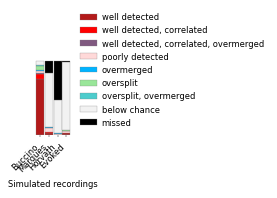

In [ ]:
# takes 2 secs

# record agreement matrices for each dataset
agreem_mxs = [agreem_mx_b, agreem_mx_m, agreem_mx_h, agreem_mx_e]
agreem_names = ["Buccino", "Marques", "Horvath", "Evoked"]

df = pd.DataFrame()

for ix, mx_i in enumerate(agreem_mxs):

    # classify sorting biases for this dataset
    bias_labels = classify_true_unit_biases(mx_i, DET_THRESH, CHANCE_THRESH)

    # calculate proportions of biases for this dataset
    biases_ratio_df = create_true_biases_df(bias_labels)
    df[agreem_names[ix]] = biases_ratio_df["cell_count"].values

df.index = biases_ratio_df.index

# plot
fig, axis = plt.subplots(1, 1, figsize=(0.5, 1))
axis = plot_biases(axis, df)
axis.set_xlabel("Simulated recordings")

# save figures
plt.savefig(
    "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/spikebias/figures/3_bias/svg/sorting_accuracy_and_biases_ks3.svg",
    **savefig_cfg,
)

### Plot biases for remaining least matching sorted single units (if any)

False positive are units that share no spikes with the ground truth units

/tmp/ipykernel_53209/1239660473.py:59: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


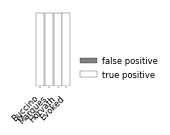

In [ ]:
# FALSE POSITIVES

# sorted units are in rows
n_false_pos = sum(agreem_mx_b.sum(axis=1) == 0)
n_sorted = agreem_mx_b.shape[0]
false_pos_ratio_b = n_false_pos / n_sorted

# sorted units are in rows
n_false_pos = sum(agreem_mx_m.sum(axis=1) == 0)
n_sorted = agreem_mx_m.shape[0]
false_pos_ratio_m = n_false_pos / n_sorted

# sorted units are in rows
n_false_pos = sum(agreem_mx_h.sum(axis=1) == 0)
n_sorted = agreem_mx_h.shape[0]
false_pos_ratio_h = n_false_pos / n_sorted

# sorted units are in rows
n_false_pos = sum(agreem_mx_e.sum(axis=1) == 0)
n_sorted = agreem_mx_e.shape[0]
false_pos_ratio_e = n_false_pos / n_sorted


df = pd.DataFrame(columns=["Buccino", "Marques", "Horvath", "Evoked"])
df["Buccino"] = [false_pos_ratio_b, 1 - false_pos_ratio_b]
df["Marques"] = [false_pos_ratio_m, 1 - false_pos_ratio_m]
df["Horvath"] = [false_pos_ratio_h, 1 - false_pos_ratio_h]
df["Evoked"] = [false_pos_ratio_e, 1 - false_pos_ratio_e]
df.index = ["false positive", "true positive"]
df

# plot
fig, axis = plt.subplots(1, 1, figsize=(0.5, 1))
ax = (df).T.plot.bar(
    ax=axis,
    stacked=True,
    color=[(0.5, 0.5, 0.5), (1, 1, 1)],
    width=0.9,
    edgecolor=[0, 0, 0],
    linewidth=0.2,
)

# set axis legend
ax.spines[["left", "right", "top", "bottom"]].set_visible(False)
y_axis = ax.axes.get_yaxis()
y_axis.set_visible(False)
ax.set_xticklabels(df.columns, rotation=45, ha="right")
ax.set_ylabel("Sorting biases (ratio)", fontsize=9)

ax.legend(
    df.index,
    ncol=1,
    loc="lower left",
    bbox_to_anchor=(1, 0),
    frameon=False,
    handletextpad=0.6,
)

plt.tight_layout()


# save figures
plt.savefig(
    "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/spikebias/figures/3_bias/svg/false_positives_ratio_ks3.svg",
    **savefig_cfg,
)

## Quality of sorted units